#### In this notebook we will use the modeling tools create for this project to create high-performing neural network models via iterative methods.

Note* that creating neural network models is very resource intensive, so while we want to create a model with high performance, we should also be conscious at times when we are using up a lot of time in search for what may just be a marginal increase in performance. I.e if we've already done a lot of time-intensive iterations and find ourselves stuck at a "resistance" level of 95% accuracy, it may not be worth spending the extra time, given the scope of this project, to achieve what seems might only be a ~0.5% increase in accuracy (or any marginal performance increase for any preferred evaluation metric). a 95% accuracy score is pretty good and should be acceptable.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

from module4_scripts.preprocessor import Preprocessor
from module4_scripts.model import DenseModel, ConvolutionalModel

In [5]:
LABELS = ["NORMAL", "PNEUMONIA"]

Below we import the compressed arrays we saved in the preprocessing notebook into this notebook. These arrays are all the 2D and 4D images(X) and labels(y) train, test, and validation sets.

In [6]:
input_sets = Preprocessor.load_arrays("npy/arrays.npz")

Reading file in path: npy/arrays.npz.npz
Loading set X_train_4D
Loading set y_train_4D
Loading set X_test_4D
Loading set y_test_4D
Loading set X_val_4D
Loading set y_val_4D
Loading set X_train_2D
Loading set y_train_2D
Loading set X_test_2D
Loading set y_test_2D
Loading set X_val_2D
Loading set y_val_2D


## Modeling

We'll now create and iterate through different model architectures. We'll start from a basic architecture and gradually increase the complexity, and take the best performing model for deployment. Note that there are likely endless variations of model network compositions that we can use that will all achieve good performance. For the scope of this project, we'll present and analyze 5 different variations (and of course, there will be many iterations leading to these 5 variations that will not be presented) to choose from.  

Another thing to consider is which metrics we should pay attention to most. Accuracy is a generic metric used to evaluate any model, and we will indeed use it. However, given the sensitive nature of the domain, we'll have to go a bit deeper than that. When it comes to medical-related tests, a False Positive should be a more acceptable error relative to a False Negative. Both are obviously unwanted, but it's likely worse to not get treated at all for an issue you actually have, than getting treated for an issue you don't actually have (depending on the risk of the treatment). Therefore, in our model, we want to make sure that we are as accurate as possible in detecting Pneumonia when the patient actually has Pneumonia. Thus, this brings our attention to the recall metric. However, this metric alone won't be a good evaluator, since if we classify every single person as having Pneumonia, our recall will be 100%, but the model precision will be very low. We'll do our best to try to find a good balance between precision and recall, with more focus on recall. The F1-score is a blend of the precision and recall metrics, so we'll look at that as well to ask "Okay, our recall is high, but how good is the actual model?" when we see high recall values. We'll also want to see high AUC under our ROC curves.

### Model 1

As a base, let's start with a simple densely connected network with 2 hidden layers with a modest number of units in each layer.

In [57]:
model1_layers = []
model1_layers.append(layers.Dense(25, activation='relu')) 
model1_layers.append(layers.Dense(50, activation='relu'))
model1_layers.append(layers.Dense(1, activation='sigmoid'))

#instantiate a DenseModel object for the first model
model1 = DenseModel(model_n="1", labels=LABELS, **input_sets)

From previous iterations of this model, we saw that using the default learning rate of 0.01 causes us to hit a local minimum very early on, so we change the learning rate parameter to start at 0.001. (Note that there is also reduce learning rate on plateu callback in place for all models.)

In [58]:
model1.build(layers=model1_layers, lr=0.001)

Initializing Sequential model...
Added model layer 1
Added model layer 2
Added model layer 3

Compiling Model: 
	Optimizer = Stochastic Gradient Descent with Momentum 
	Loss Function = Binary Crossentropy 
	Metrics = Accuracy, Precision, Recall, AUC

Completed model compilation.


Training Params: {
    "epochs": 150,
    "batch_size": 100,
    "steps_per_epoch": 100,
    "weighted": true,
    "workers": 8,
    "lr_reduction_factor": 0.5,
    "lr_patience": 7,
    "early_stopping_patience": 14
}

Class Weights: {
    "NORMAL": 1.8517786561264822,
    "PNEUMONIA": 0.6849415204678363
}

Epoch 1/150
100/100 [==============================] - 5s 37ms/step - loss: 0.6903 - accuracy: 0.5843 - precision: 0.7903 - recall: 0.5828 - auc: 0.6044 - val_loss: 0.8105 - val_accuracy: 0.3402 - val_precision: 1.0000 - val_recall: 0.0918 - val_auc: 0.9359
Epoch 2/150
100/100 [==============================] - 3s 32ms/step - loss: 0.5944 - accuracy: 0.7028 - precision: 0.8380 - recall: 0.7356 - auc: 0.7437 - val_loss: 0.5530 - val_accuracy: 0.7385 - val_precision: 0.9928 - val_recall: 0.6447 - val_auc: 0.9643
Epoch 3/150
100/100 [==============================] - 3s 33ms/step - loss: 0.5405 - accuracy: 0.7476 - precision: 0.8637 - recall: 0.7777 - auc: 0.8039 - val_loss: 0.4503 - 

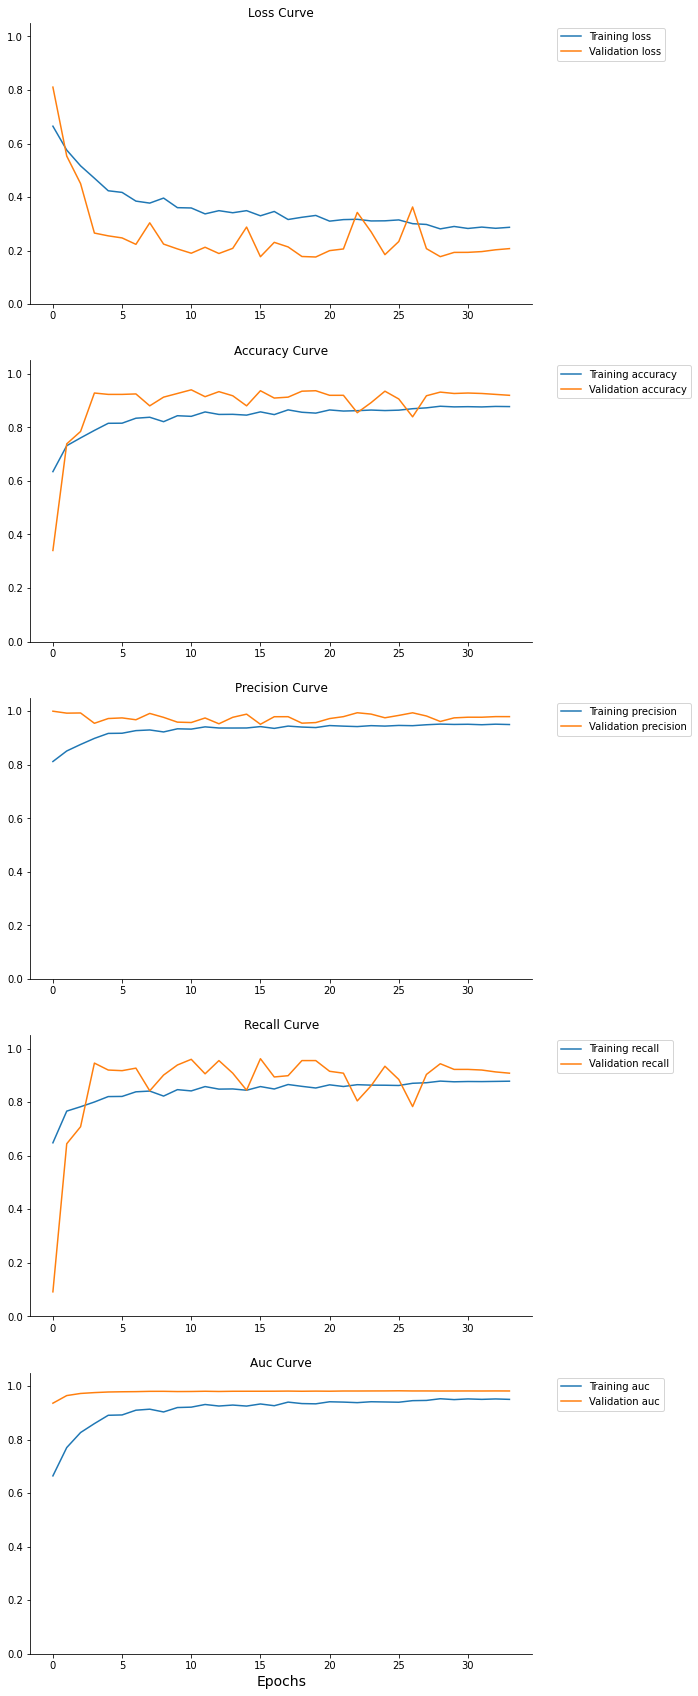

In [59]:
model1.train()

The callbacks ended the model training at 34 epochs. From the curves above, we see that there is generally a higher performance in the validation sets than the training sets, signifying some underfitting. Although, performance on the training set is just okay and the validation set is decent considering the simplicity of the model. 

Evaluating best model...

=== Evaluating best model on Train set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.79      0.80      0.80      2530
   PNEUMONIA       0.93      0.92      0.92      6840

    accuracy                           0.89      9370
   macro avg       0.86      0.86      0.86      9370
weighted avg       0.89      0.89      0.89      9370
 

Loss: 0.2651241719722748 
Accuracy: 0.8899679780006409


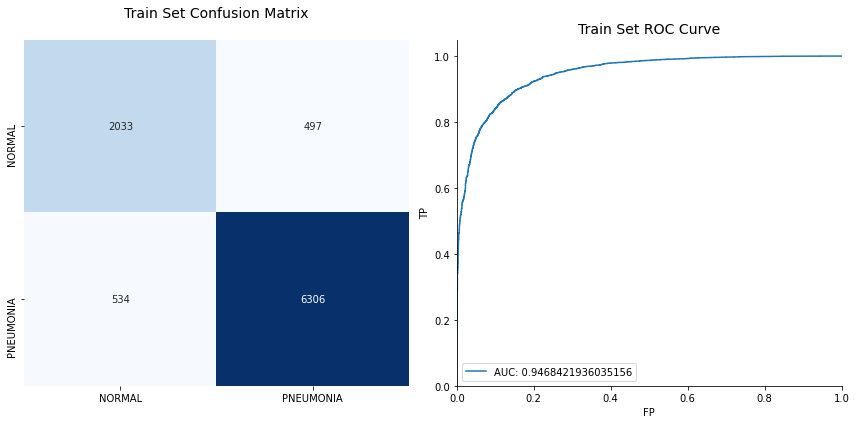

=== Evaluating best model on Validation set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.88      0.89      0.88       160
   PNEUMONIA       0.96      0.96      0.96       425

    accuracy                           0.94       585
   macro avg       0.92      0.92      0.92       585
weighted avg       0.94      0.94      0.94       585
 

Loss: 0.17617075145244598 
Accuracy: 0.9367521405220032


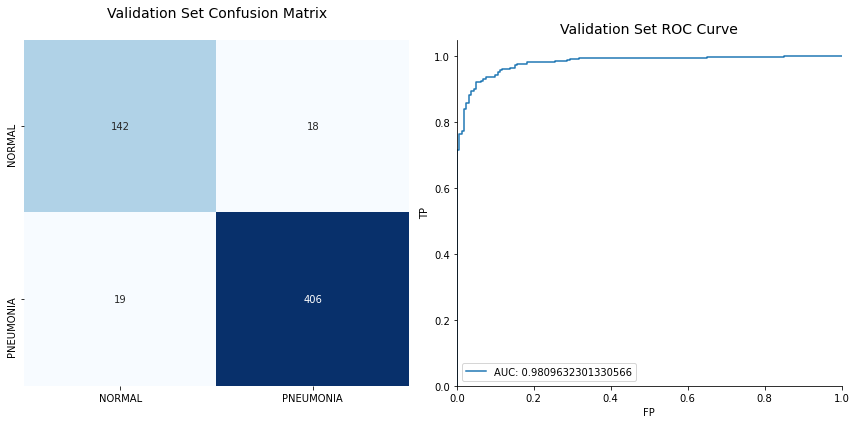

=== Evaluating best model on Test set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.85      0.87      0.86       158
   PNEUMONIA       0.95      0.94      0.95       428

    accuracy                           0.92       586
   macro avg       0.90      0.90      0.90       586
weighted avg       0.92      0.92      0.92       586
 

Loss: 0.21416841447353363 
Accuracy: 0.9215016961097717


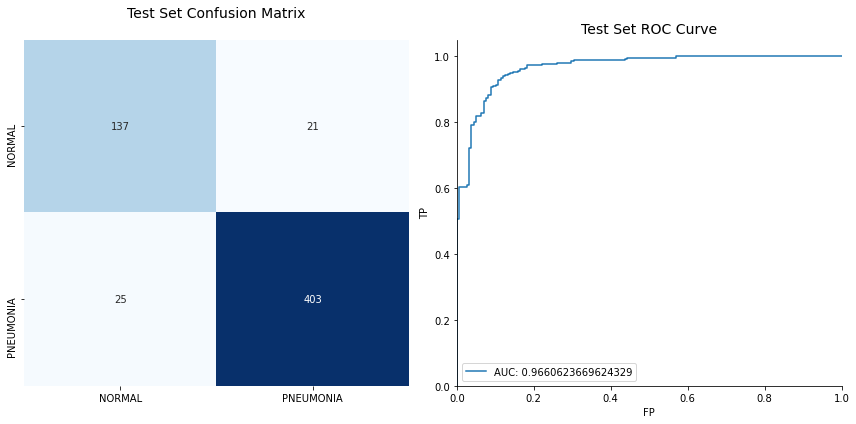

In [60]:
model1.evaluate()

The model evaluation on the test set shows pretty okay performance given network simplicity. We have a loss of 0.214 and an accuracy of 92.15%. The false negative rate for pneumonia is 25/428=5.88%, and AUC is at 0.966. The false negative rate is a bit high, especially given this is a medical-related domain, so we'll definitely want to improve it. Nonetheless, the performance is pretty decent for a baseline dense network.

### Model 2 - convolutonal network with an initial convolving layer and dense layers

For the next step, let's take the same densely connected network but add an initial convolving layer, transforming this into a "convolutional" neural network. Convolutional networks differ from dense networks in that convolutional networks identify patterns in local regions and apply those patterns and insights into other regions. This saves processing time compared to highly-dimensional densely connected networks. 

We'll now add one convolving layer with 256 filters to the densely connected network created in Model 1, and then train and evaluate the new model.  

In [61]:
model2_layers = []
model2_layers.append(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model2_layers.append(layers.MaxPooling2D((2, 2)))
model2_layers.append(layers.Flatten())
model2_layers.append(layers.Dense(25, activation='relu'))
model2_layers.append(layers.Dense(50, activation='relu'))
model2_layers.append(layers.Dense(1, activation='sigmoid'))

#instantiate a ConvolutionalModel object for the first model
model2 = ConvolutionalModel(model_n="2", labels=LABELS, **input_sets)

In [62]:
model2.build(layers=model2_layers)

Initializing Sequential model...
Added model layer 1
Added model layer 2
Added model layer 3
Added model layer 4
Added model layer 5
Added model layer 6

Compiling Model: 
	Optimizer = Stochastic Gradient Descent with Momentum 
	Loss Function = Binary Crossentropy 
	Metrics = Accuracy, Precision, Recall, AUC

Completed model compilation.


Training Params: {
    "epochs": 150,
    "batch_size": 50,
    "steps_per_epoch": 100,
    "weighted": true,
    "workers": 8,
    "lr_reduction_factor": 0.5,
    "lr_patience": 7,
    "early_stopping_patience": 14
}

Class Weights: {
    "NORMAL": 1.8517786561264822,
    "PNEUMONIA": 0.6849415204678363
}

Epoch 1/150
100/100 [==============================] - 11s 98ms/step - loss: 0.7010 - accuracy: 0.3818 - precision: 0.7253 - recall: 0.2321 - auc: 0.5230 - val_loss: 0.7024 - val_accuracy: 0.2803 - val_precision: 1.0000 - val_recall: 0.0094 - val_auc: 0.9294
Epoch 2/150
100/100 [==============================] - 9s 93ms/step - loss: 0.6683 - accuracy: 0.4821 - precision: 0.8727 - recall: 0.3491 - auc: 0.6940 - val_loss: 0.8191 - val_accuracy: 0.2957 - val_precision: 1.0000 - val_recall: 0.0306 - val_auc: 0.9563
Epoch 3/150
100/100 [==============================] - 9s 94ms/step - loss: 0.6246 - accuracy: 0.6751 - precision: 0.8524 - recall: 0.6802 - auc: 0.7095 - val_loss: 0.6366 - 

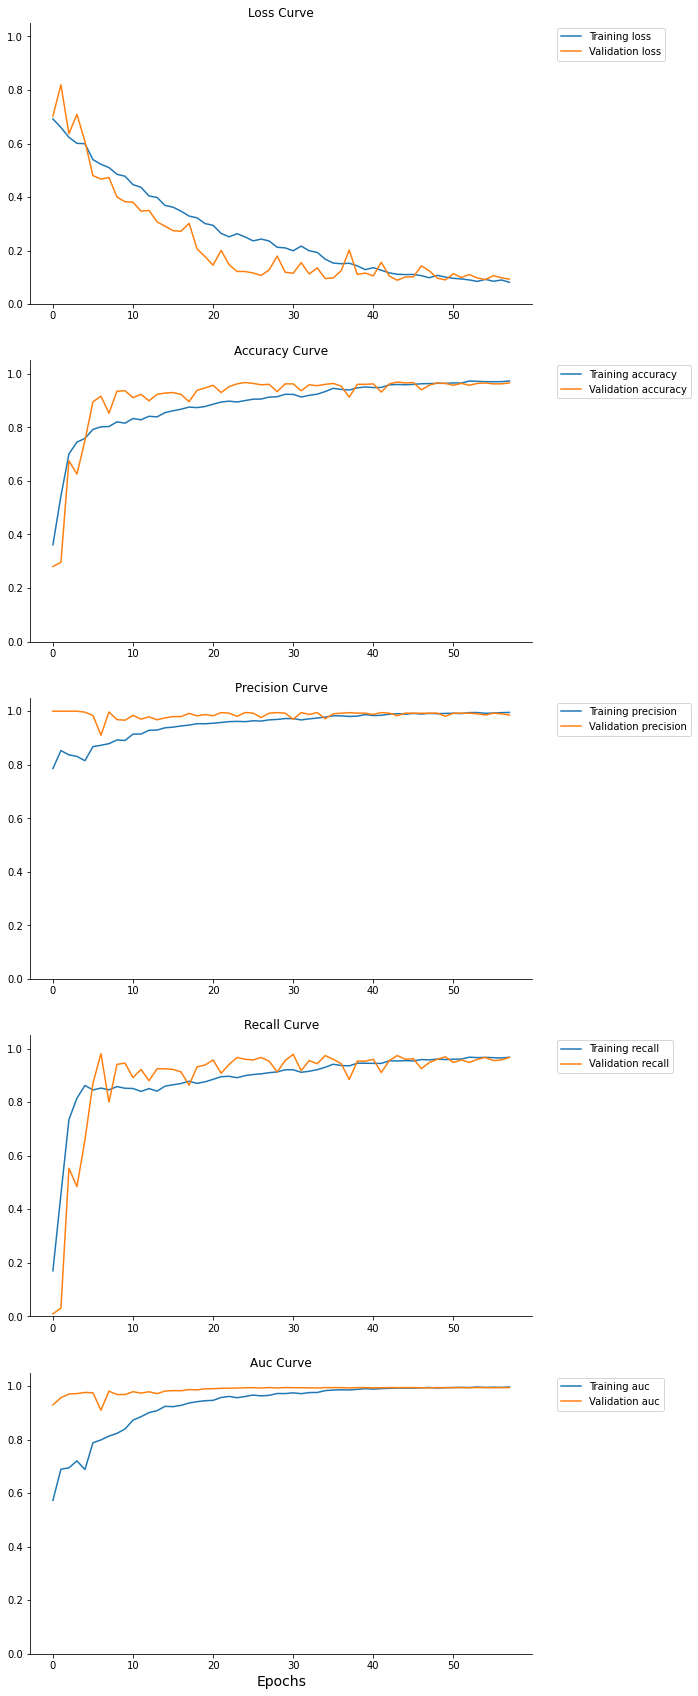

In [63]:
model2.train(batch_size=50)

This model trained a bit longer than the first, with the callbacks in place stopping the training at 58 epochs. We see some initial oscillations in validation set performance with eventual smoothing and convergence. So this model training performance actually looks quite good.

Evaluating best model...

=== Evaluating best model on Train set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.93      0.95      0.94      2530
   PNEUMONIA       0.98      0.97      0.98      6840

    accuracy                           0.97      9370
   macro avg       0.96      0.96      0.96      9370
weighted avg       0.97      0.97      0.97      9370
 

Loss: 0.09709762781858444 
Accuracy: 0.9669156670570374


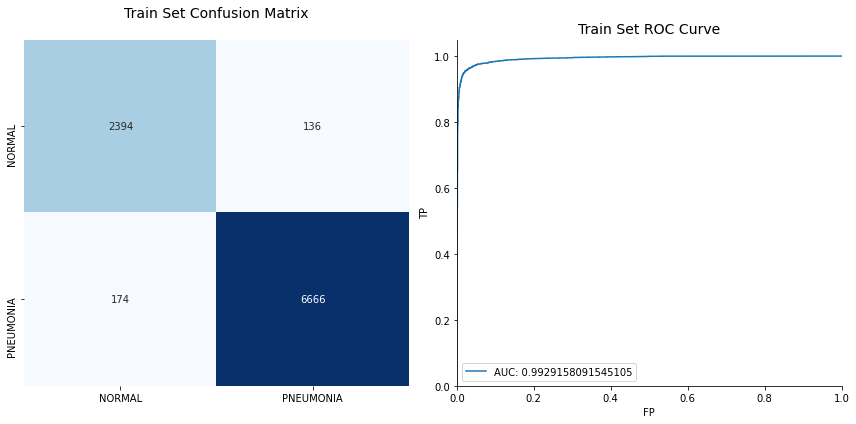

=== Evaluating best model on Validation set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.93      0.96      0.94       160
   PNEUMONIA       0.98      0.97      0.98       425

    accuracy                           0.97       585
   macro avg       0.96      0.97      0.96       585
weighted avg       0.97      0.97      0.97       585
 

Loss: 0.08928441256284714 
Accuracy: 0.9692307710647583


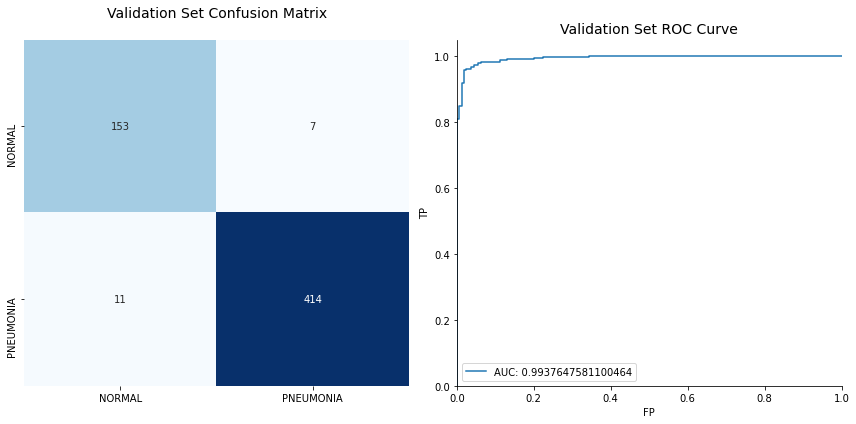

=== Evaluating best model on Test set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.93      0.92      0.93       158
   PNEUMONIA       0.97      0.97      0.97       428

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586
 

Loss: 0.11965231597423553 
Accuracy: 0.9607508778572083


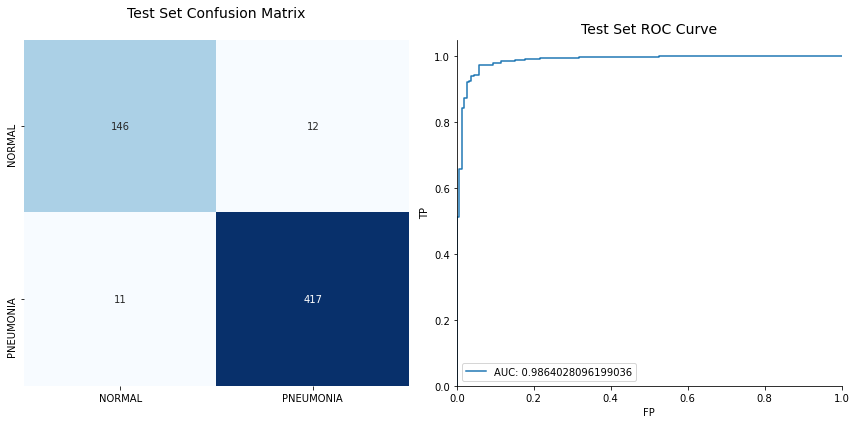

In [64]:
model2.evaluate()

The model evaluation for this model shows an improvement in performance in the test set as well as a very balanced performance overall for all sets, signifying great fit. The AUC under the ROC curve in the test set is 0.9864, and the false negative error for pneumonia is 11/428=2.57%, a significant improvement from the first model. The overall accuracy for this model is 96.08%, which is also pretty good!

### Model 3 - convolutional network with a convolutional base (pretrained network) and dense layers

The addition of the convolving layer in Model 2 yielded some interesting results, but we only used a simple convolving layer with 256 filters. Now, let's try out using a pretrained convolutional base for our model to prepend to the densely connected network created in Model 1. A pretrained dataset is a neural network that was previously ran on a large, general dataset, and then made public. This serves as a generic model which can be applied as a base to many different computer vision tasks. A common network that is used for image recognition is the VGG-19 network, so we'll try that out below and see if we get better performance results.

In [65]:
#import VGG19
from tensorflow.keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(256, 256, 3))
cnn_base.trainable = False

In [66]:
model3_layers = []
model3_layers.append(cnn_base)
model3_layers.append(layers.Flatten())
model3_layers.append(layers.Dense(25, activation='relu'))
model3_layers.append(layers.Dense(50, activation='relu'))
model3_layers.append(layers.Dense(1, activation='sigmoid'))

In [67]:
model3 = ConvolutionalModel(model_n="3", labels=LABELS, **input_sets)

In [68]:
model3.build(layers=model3_layers)

Initializing Sequential model...
Added model layer 1
Added model layer 2
Added model layer 3
Added model layer 4
Added model layer 5

Compiling Model: 
	Optimizer = Stochastic Gradient Descent with Momentum 
	Loss Function = Binary Crossentropy 
	Metrics = Accuracy, Precision, Recall, AUC

Completed model compilation.


Training Params: {
    "epochs": 100,
    "batch_size": 50,
    "steps_per_epoch": 100,
    "weighted": true,
    "workers": 8,
    "lr_reduction_factor": 0.5,
    "lr_patience": 7,
    "early_stopping_patience": 14
}

Class Weights: {
    "NORMAL": 1.8517786561264822,
    "PNEUMONIA": 0.6849415204678363
}

Epoch 1/100
100/100 [==============================] - 13s 123ms/step - loss: 0.6787 - accuracy: 0.5912 - precision: 0.7844 - recall: 0.6043 - auc: 0.6139 - val_loss: 0.4476 - val_accuracy: 0.8991 - val_precision: 0.9507 - val_recall: 0.9082 - val_auc: 0.9656
Epoch 2/100
100/100 [==============================] - 12s 117ms/step - loss: 0.5086 - accuracy: 0.7548 - precision: 0.9058 - recall: 0.7404 - auc: 0.8327 - val_loss: 0.2544 - val_accuracy: 0.8923 - val_precision: 0.8819 - val_recall: 0.9835 - val_auc: 0.9685
Epoch 3/100
100/100 [==============================] - 12s 118ms/step - loss: 0.4316 - accuracy: 0.7897 - precision: 0.9360 - recall: 0.7658 - auc: 0.8752 - val_loss: 0.26

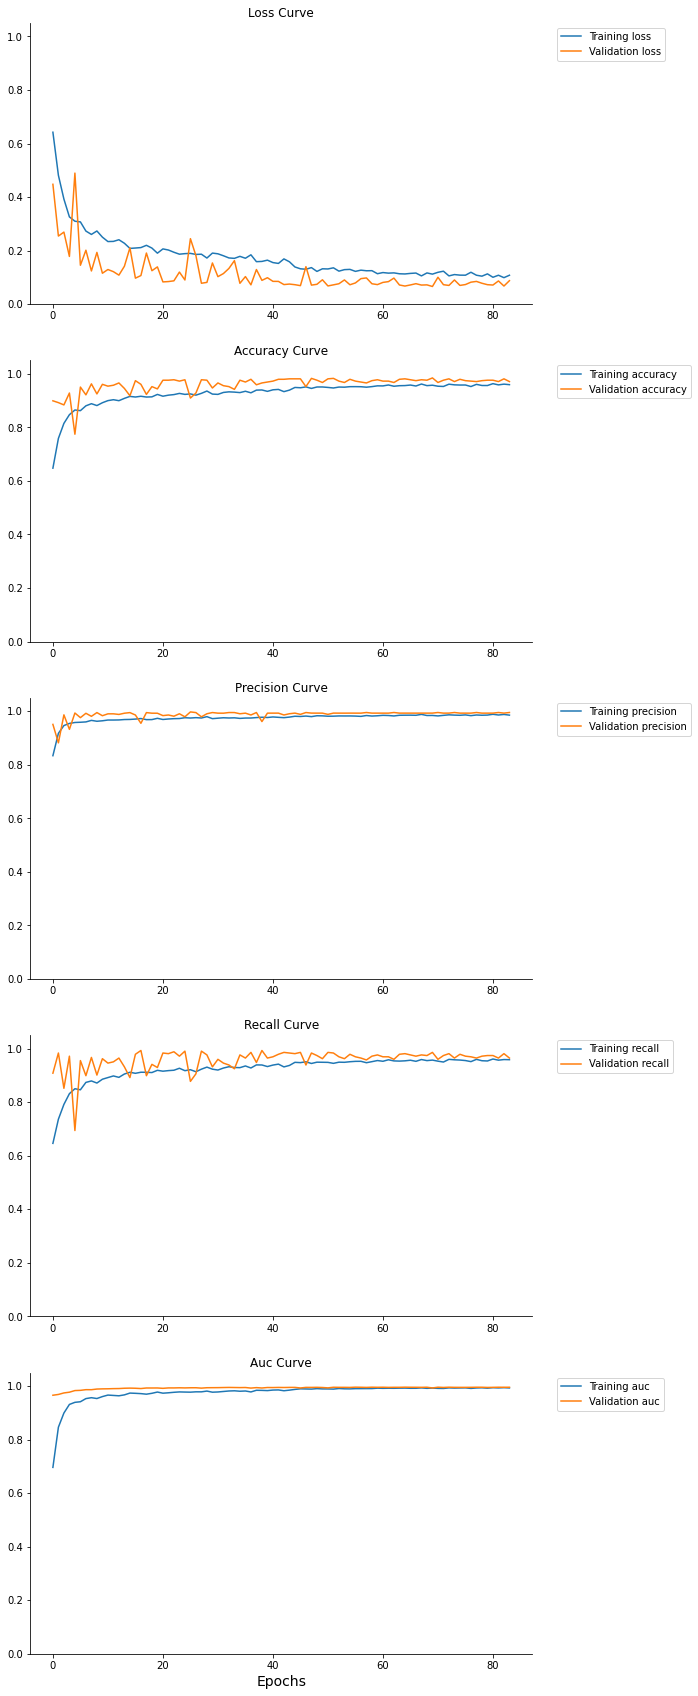

In [69]:
model3.train(epochs=100, batch_size=50)

The callbacks stopped the model training at 84 epochs, so the model training actually ran for a while. Looks like a general food fit between validation and training sets, with near convergence on the loss and accuracy curves. Let's proceed with model evaluation below.

Evaluating best model...

=== Evaluating best model on Train set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.93      0.93      0.93      2530
   PNEUMONIA       0.97      0.97      0.97      6840

    accuracy                           0.96      9370
   macro avg       0.95      0.95      0.95      9370
weighted avg       0.96      0.96      0.96      9370
 

Loss: 0.09745488315820694 
Accuracy: 0.9616862535476685


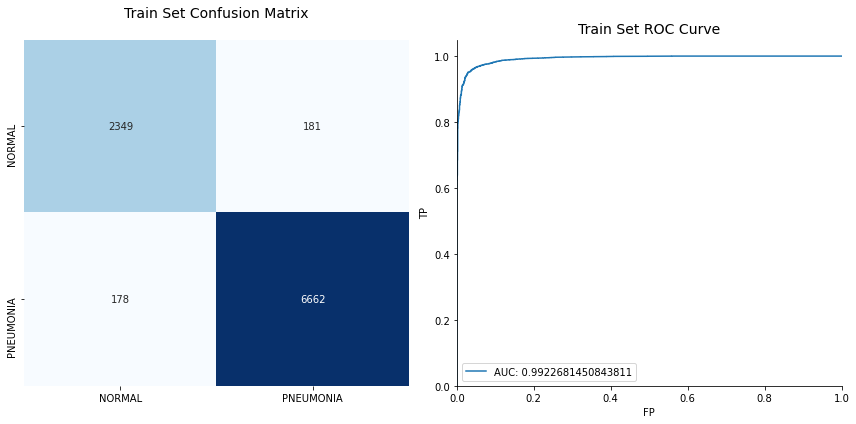

=== Evaluating best model on Validation set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       160
   PNEUMONIA       0.99      0.99      0.99       425

    accuracy                           0.98       585
   macro avg       0.98      0.98      0.98       585
weighted avg       0.98      0.98      0.98       585
 

Loss: 0.06604129076004028 
Accuracy: 0.9846153855323792


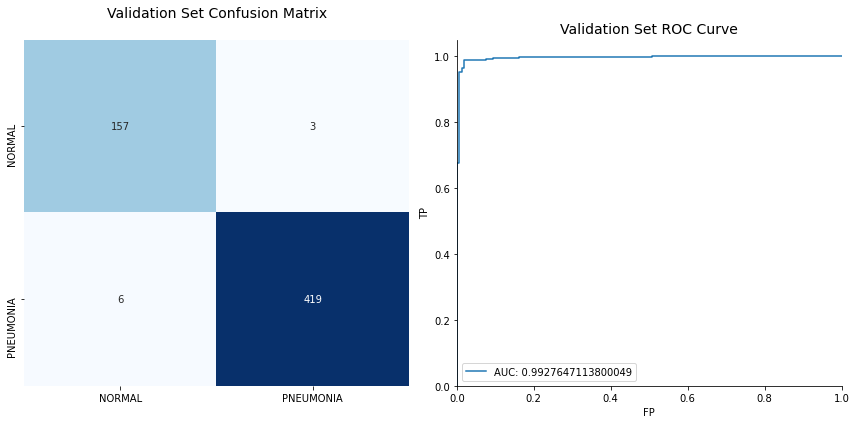

=== Evaluating best model on Test set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       158
   PNEUMONIA       0.97      0.96      0.97       428

    accuracy                           0.95       586
   macro avg       0.94      0.94      0.94       586
weighted avg       0.95      0.95      0.95       586
 

Loss: 0.13198599219322205 
Accuracy: 0.9505119323730469


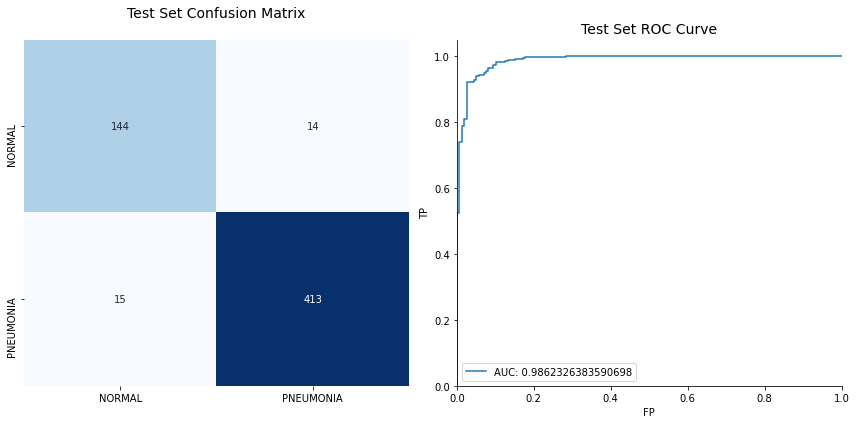

In [70]:
model3.evaluate()

This model actually performed slightly worse than Model2. The AUC is the same but there is higher loss and lower accuracy. The false negative error is 15/428=3.5%, a ~1% increase from Model 2. So it looks like the pretained network alone stiched to a simple dense network doesn't yield better results than a manually added convolving layer, even though the pretrained network is a lot more complex. A pretrained network is supposed to be very generic, and doesn't cater to every computer vision task out there. It did not necessarily perform poorly here, just not the best from what we've seen so far. Let's continue trying to add model complexity, keeping the pretrained network in the overall network, and see if there's anything to gain.

### Model 4 - convolutional network with convolutional base, additional convolving layers, and dense layers

For the next model iteration we'll try to combine the elements of the first 3 models. Thus, we'll begin the network with a pretrained convolutional base, and basically stitch Model 2 on top of that, which is a convolving layer and 2 dense layers.

In [71]:
model4_layers = []
model4_layers.append(cnn_base)
model4_layers.append(layers.Conv2D(256, (3, 3), activation='relu'))
model4_layers.append(layers.MaxPooling2D((2, 2)))
model4_layers.append(layers.Flatten())
model4_layers.append(layers.Dense(25, activation='relu'))
model4_layers.append(layers.Dense(50, activation='relu'))
model4_layers.append(layers.Dense(1, activation='sigmoid'))

In [72]:
model4 = ConvolutionalModel(model_n="4", labels=LABELS, **input_sets)

In [73]:
model4.build(layers=model4_layers)

Initializing Sequential model...
Added model layer 1
Added model layer 2
Added model layer 3
Added model layer 4
Added model layer 5
Added model layer 6
Added model layer 7

Compiling Model: 
	Optimizer = Stochastic Gradient Descent with Momentum 
	Loss Function = Binary Crossentropy 
	Metrics = Accuracy, Precision, Recall, AUC

Completed model compilation.


Training Params: {
    "epochs": 100,
    "batch_size": 50,
    "steps_per_epoch": 100,
    "weighted": true,
    "workers": 8,
    "lr_reduction_factor": 0.5,
    "lr_patience": 7,
    "early_stopping_patience": 14
}

Class Weights: {
    "NORMAL": 1.8517786561264822,
    "PNEUMONIA": 0.6849415204678363
}

Epoch 1/100
100/100 [==============================] - 14s 124ms/step - loss: 0.6233 - accuracy: 0.6188 - precision: 0.8429 - recall: 0.5509 - auc: 0.7459 - val_loss: 0.3664 - val_accuracy: 0.8632 - val_precision: 0.9887 - val_recall: 0.8212 - val_auc: 0.9691
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.4185 - accuracy: 0.8073 - precision: 0.9293 - recall: 0.7983 - auc: 0.8914 - val_loss: 0.6273 - val_accuracy: 0.6940 - val_precision: 0.9920 - val_recall: 0.5835 - val_auc: 0.9761
Epoch 3/100
100/100 [==============================] - 12s 119ms/step - loss: 0.3214 - accuracy: 0.8597 - precision: 0.9549 - recall: 0.8463 - auc: 0.9394 - val_loss: 0.16

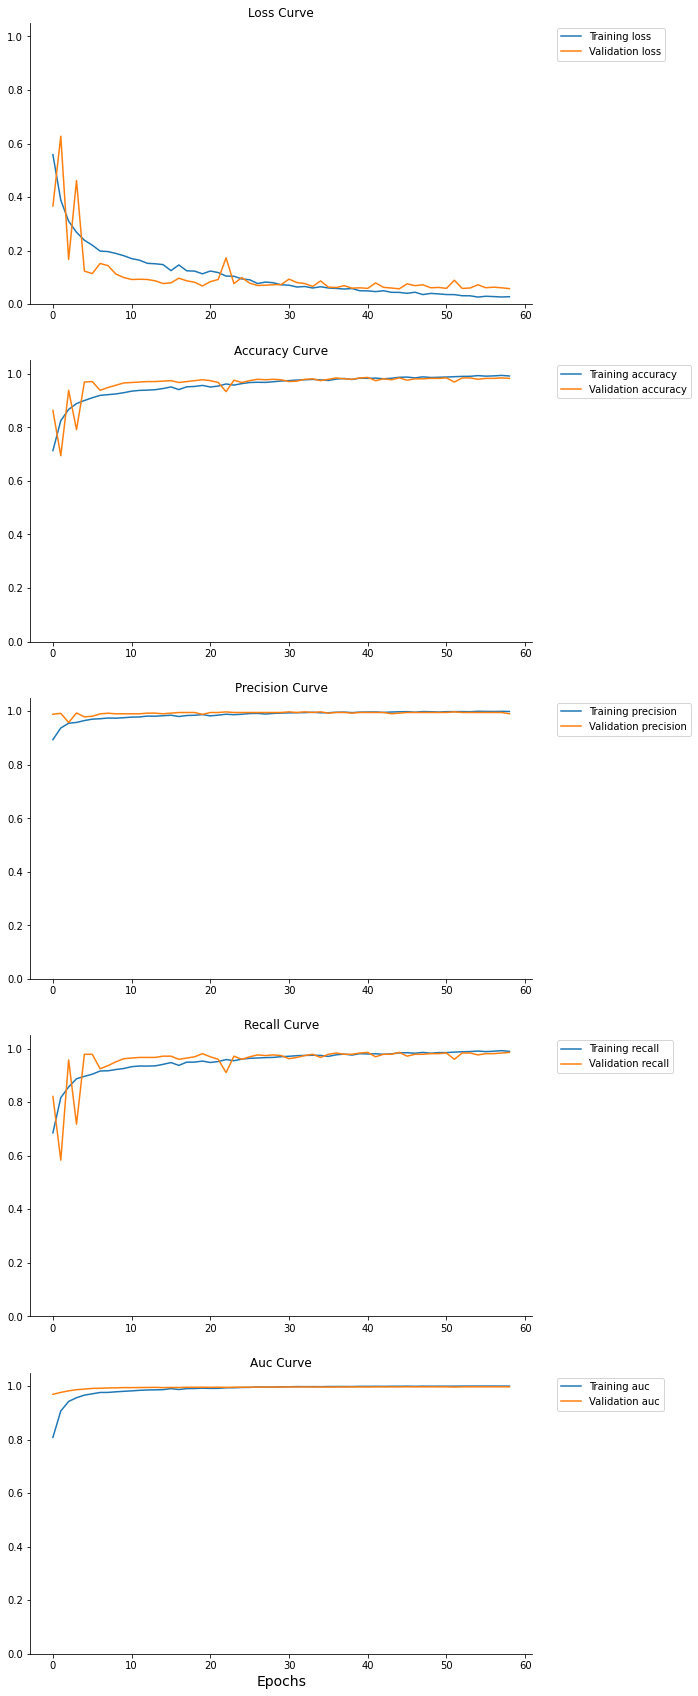

In [74]:
model4.train(epochs=100, batch_size=50)

From the curves we see the validation sets exhibiting initial oscillations before smoothing outand converging with the train set at just before 30 epochs. After that, the model starts to show signs of overfitting as training performance increases and validation performance remains stagnant, to which the callbacks eventually end the training. The model checkpoint callback should capture the epoch around the convergence period. 

Evaluating best model...

=== Evaluating best model on Train set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.98      2530
   PNEUMONIA       1.00      0.99      0.99      6840

    accuracy                           0.99      9370
   macro avg       0.99      0.99      0.99      9370
weighted avg       0.99      0.99      0.99      9370
 

Loss: 0.03580164536833763 
Accuracy: 0.9907150268554688


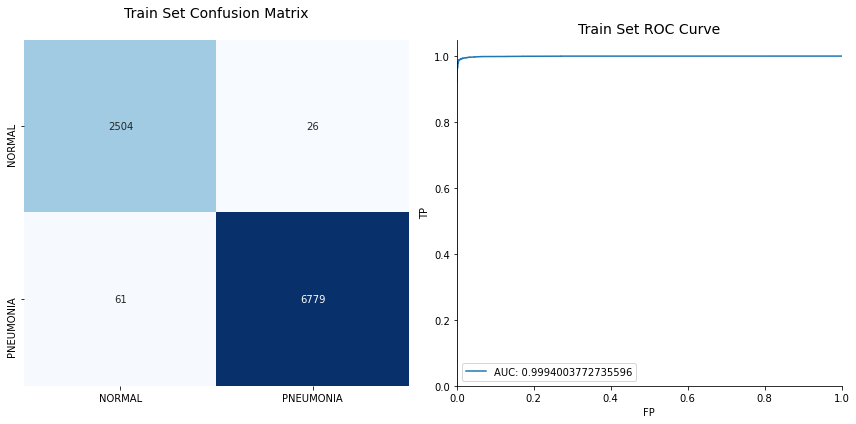

=== Evaluating best model on Validation set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       160
   PNEUMONIA       0.99      0.99      0.99       425

    accuracy                           0.98       585
   macro avg       0.98      0.98      0.98       585
weighted avg       0.98      0.98      0.98       585
 

Loss: 0.05726911872625351 
Accuracy: 0.9846153855323792


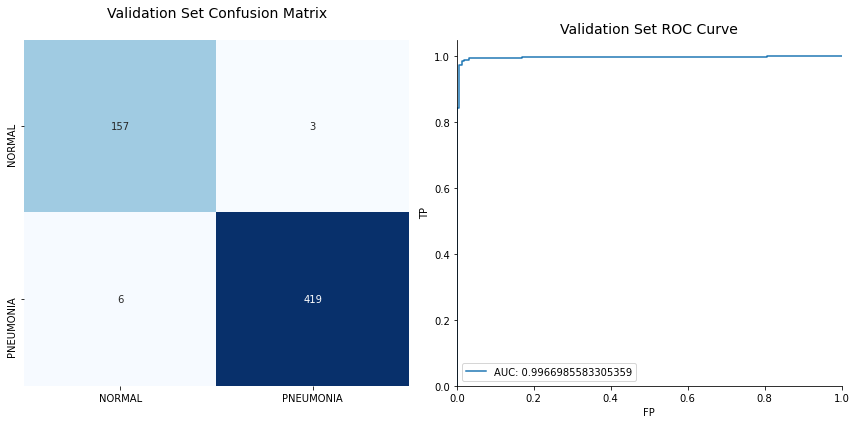

=== Evaluating best model on Test set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.91      0.94      0.93       158
   PNEUMONIA       0.98      0.96      0.97       428

    accuracy                           0.96       586
   macro avg       0.94      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586
 

Loss: 0.10615725070238113 
Accuracy: 0.9590443968772888


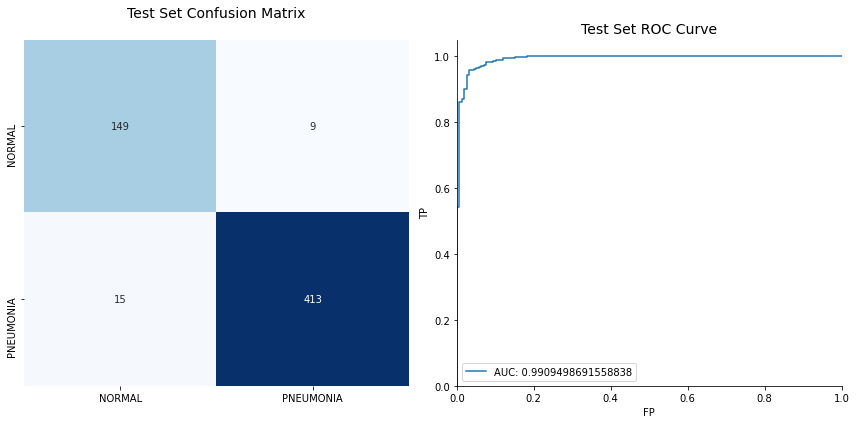

In [75]:
model4.evaluate()

The evaluation for this model is a bit interesting. The test set for this model has the highest AUC score, the lowest false positive rate, and the 2nd best accuracy thus far. This all sounds great, but it's not quite what we're looking for. Remember, we're moreso focusing on false negatives, and this model has the same false negative rate as model 3, 15/428=3.5%. 

### Model 5 - convolutional network with convolutional base, multiple convolving layers, and added dense layers.

For the last model variations, we'll basically take Model 4 and add some complexity to it. That is to say, we'll add an extra convolving layer and 2 extra dense layers. The goal here how much, if at all, added model complexity will boost performance.

In [76]:
model5_layers = []
model5_layers.append(cnn_base)
model5_layers.append(layers.Conv2D(128, (3, 3), activation='relu'))
model5_layers.append(layers.MaxPooling2D((2, 2)))
model5_layers.append(layers.Conv2D(256, (3, 3), activation='relu'))
model5_layers.append(layers.MaxPooling2D((2, 2), padding="same"))
model5_layers.append(layers.Flatten())
model5_layers.append(layers.Dense(25, activation='relu'))
model5_layers.append(layers.Dense(50, activation='relu'))
model5_layers.append(layers.Dense(75, activation='relu'))
model5_layers.append(layers.Dense(100, activation='relu'))
model5_layers.append(layers.Dense(1, activation='sigmoid'))

In [77]:
model5 = ConvolutionalModel(model_n="5", labels=LABELS, **input_sets)

In [78]:
model5.build(layers=model5_layers)

Initializing Sequential model...
Added model layer 1
Added model layer 2
Added model layer 3
Added model layer 4
Added model layer 5
Added model layer 6
Added model layer 7
Added model layer 8
Added model layer 9
Added model layer 10
Added model layer 11

Compiling Model: 
	Optimizer = Stochastic Gradient Descent with Momentum 
	Loss Function = Binary Crossentropy 
	Metrics = Accuracy, Precision, Recall, AUC

Completed model compilation.


Training Params: {
    "epochs": 100,
    "batch_size": 50,
    "steps_per_epoch": 100,
    "weighted": true,
    "workers": 8,
    "lr_reduction_factor": 0.5,
    "lr_patience": 7,
    "early_stopping_patience": 14
}

Class Weights: {
    "NORMAL": 1.8517786561264822,
    "PNEUMONIA": 0.6849415204678363
}

Epoch 1/100
100/100 [==============================] - 14s 125ms/step - loss: 0.6690 - accuracy: 0.5274 - precision: 0.8661 - recall: 0.4053 - auc: 0.7034 - val_loss: 0.4533 - val_accuracy: 0.8291 - val_precision: 0.8143 - val_recall: 0.9906 - val_auc: 0.9590
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.5505 - accuracy: 0.7008 - precision: 0.8839 - recall: 0.6834 - auc: 0.7984 - val_loss: 0.3581 - val_accuracy: 0.8769 - val_precision: 0.9836 - val_recall: 0.8447 - val_auc: 0.9654
Epoch 3/100
100/100 [==============================] - 12s 119ms/step - loss: 0.4024 - accuracy: 0.8173 - precision: 0.9408 - recall: 0.7980 - auc: 0.9034 - val_loss: 0.19

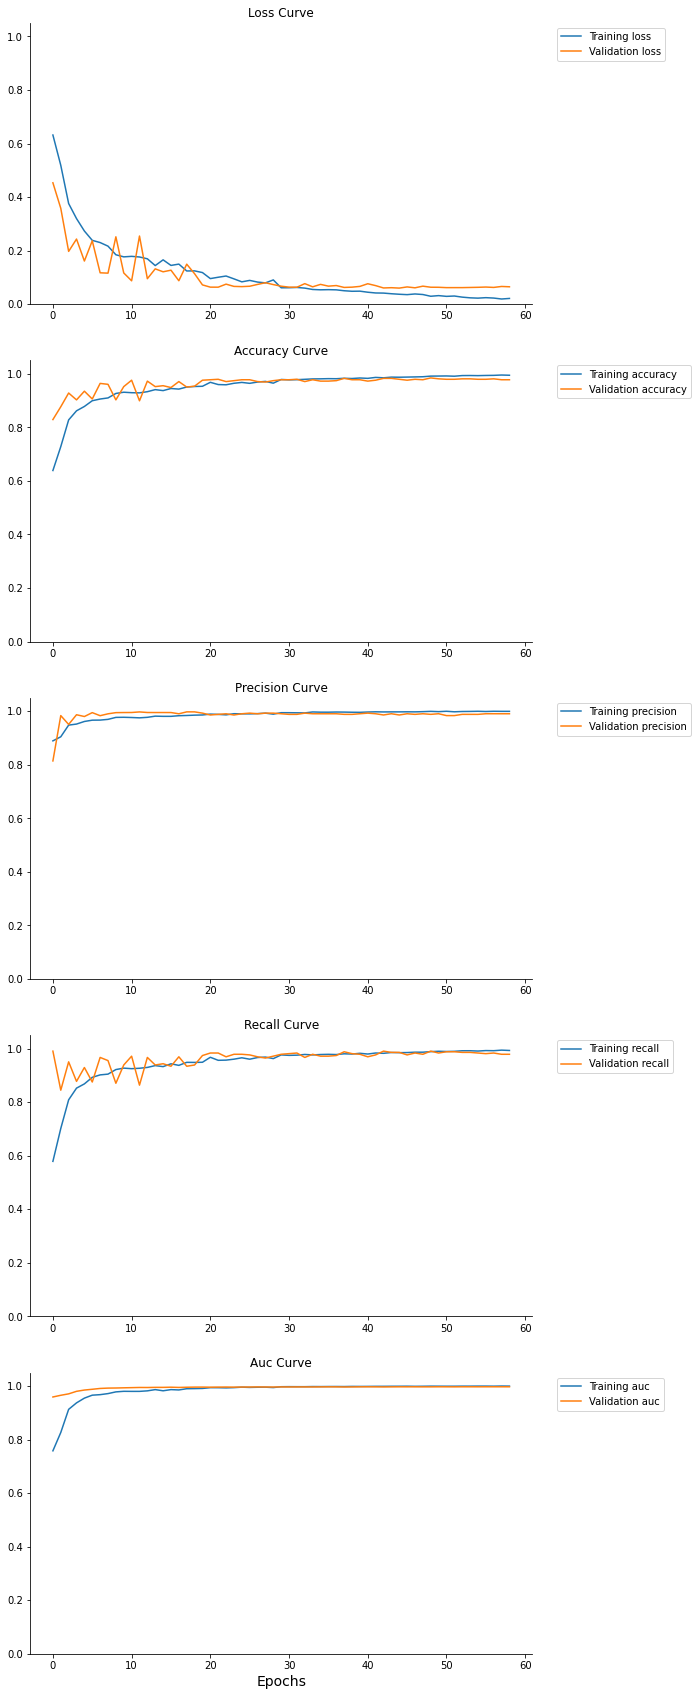

In [79]:
model5.train(epochs=100, batch_size=50)

Training performance metric curves are very similar to that of model 4. We see a convergence at just around 30 epochs, and then overfitting beginning after that, to which the callbacks eventually terminate the training.

Evaluating best model...

=== Evaluating best model on Train set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.99      2530
   PNEUMONIA       1.00      0.99      0.99      6840

    accuracy                           0.99      9370
   macro avg       0.99      0.99      0.99      9370
weighted avg       0.99      0.99      0.99      9370
 

Loss: 0.03098362497985363 
Accuracy: 0.9924226403236389


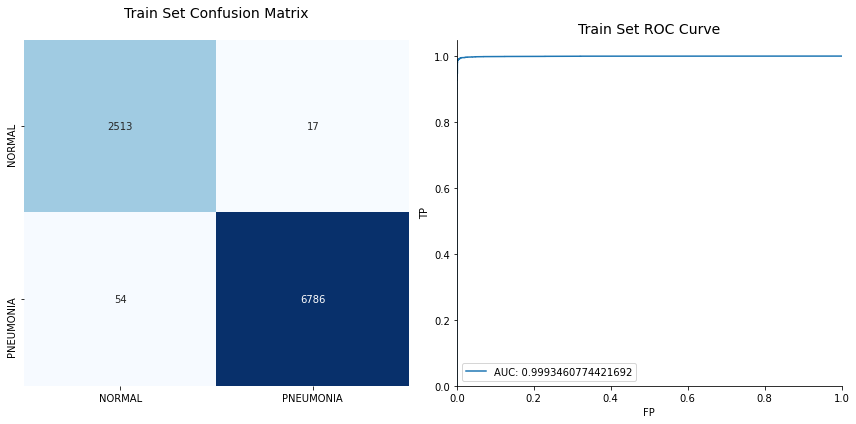

=== Evaluating best model on Validation set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.96      0.96      0.96       160
   PNEUMONIA       0.99      0.99      0.99       425

    accuracy                           0.98       585
   macro avg       0.97      0.97      0.97       585
weighted avg       0.98      0.98      0.98       585
 

Loss: 0.06002464145421982 
Accuracy: 0.9794871807098389


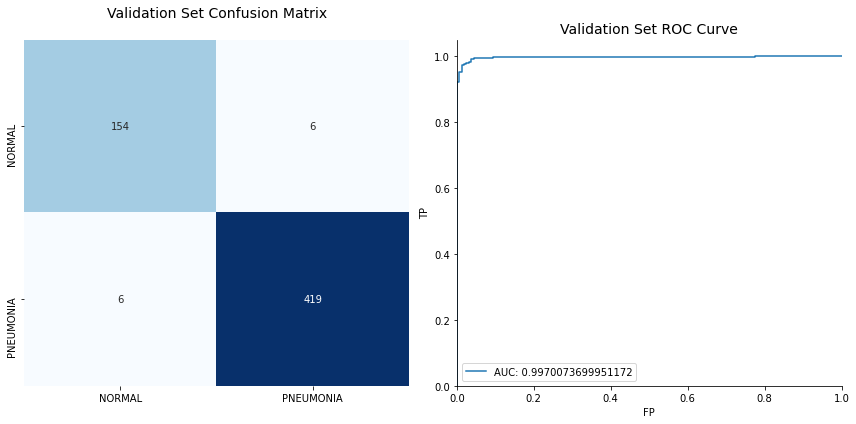

=== Evaluating best model on Test set ===

Classification Report
               precision    recall  f1-score   support

      NORMAL       0.91      0.93      0.92       158
   PNEUMONIA       0.97      0.97      0.97       428

    accuracy                           0.96       586
   macro avg       0.94      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586
 

Loss: 0.13018669188022614 
Accuracy: 0.9573378562927246


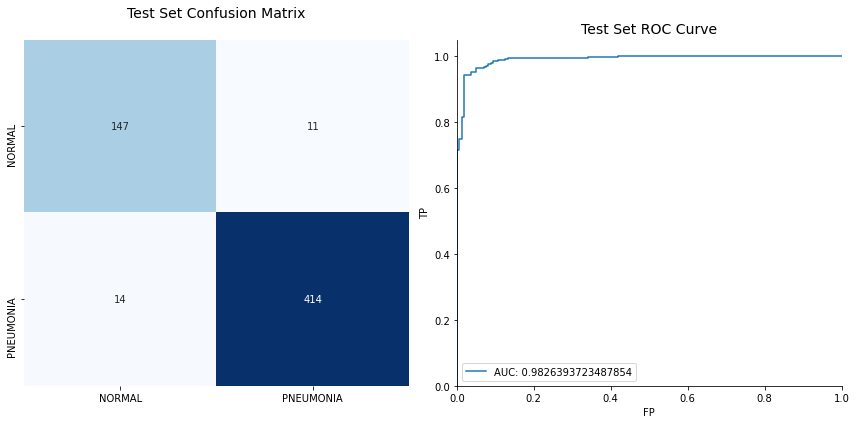

In [80]:
model5.evaluate()

The test set evaluation for this model shows a more balanced error than model 4, but with lower AUC, higher loss, and lower accuracy. Even though the errors are more balanced, Model 2 still has the most balanced errors, and the highest accuracy. Thus, we can conclude that Model 5 does not add much more value than Model 4 was, and if we we're to pick between 4 and 5, 4 would be the better one to go with.

### So, which is the best model?

From above, we conclude that the best model has to be either model 2 or model 4. Both models have their strengths and weakness relative to each other. Model 4 has lower loss, better AUC, higher precision, and a lower false postive rate, whereas model 2 has better accuracy, a lower false negative rate, higher recall, and a more balanced error distribution. Given what we discussed about the metric focuses for this domain, I'd go with model 2 as the one to deploy, since it is a great performing model and has the lowest false negative rate. Let's take a final look at the model summary/structure below. 

In [6]:
best_model = models.load_model("model/best_model_2.h5")

In [7]:
best_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4129024)           0         
_________________________________________________________________
dense_51 (Dense)             (None, 25)                103225625 
_________________________________________________________________
dense_52 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 51        
Total params: 103,234,144
Trainable params: 103,234,144
Non-trainable params: 0
_______________________________________

### Future Work

The best model found in this project is unlikely to be the absolute best model for this problem. There are endless amounts of iterations/combinations of networks that can be tested to find a truly optimal model, but this would require sufficient resources. Resource availability was the biggest bottleneck for this project, and is a general problem to consider for any deep learning project. To run this project, I subscribed to a monthly membership of Google Colab pro to tap in to their GPU resources, but even for pro members, there are limits. If institutional-level infrastructure and resources were available, this project could have been scaled to run many different combinations of model networks simultanouesly. This could mean trying out different combinations of dense layers, numers of nodes, convolving layer structures (as well as number of convolving layers), different pretrained networks etc. and many more. 

Nevertheless, the module created for this project contains solid infrastructure for model building in a simple to use way, and can definitely be scaled to perform higher-level intensity iterations.